## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from IPython.display import display, Markdown

from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

%matplotlib inline
%config IPCompleter.greedy=True
warnings.filterwarnings('ignore')
sns.set()

### Descargar datos de 
https://www.kaggle.com/uciml/aps-failure-at-scania-trucks-data-set/data

### Funciones de utilidad


In [2]:
# Plotea histograma de datos
# función tomada de https://www.kaggle.com/romulomadu/minimizing-total-cost-result-9020-00
def bar(acumm_data):
    # Do plot
    fig = plt.figure(figsize=(10,7))
    ax = fig.add_subplot(111)
    ax = sns.barplot(x=acumm_data.index, y=acumm_data.values, palette='tab20b', ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)    
    return ax

#Plotea la matriz de confución
def print_binary_confusion_matrix(matrix):    
    TN = matrix[0,0]
    FN = matrix[1,0]
    FP = matrix[0,1]
    TP = matrix[1,1]

    print ('              +-----------------+')
    print ('              |   Predicción    |')
    print ('              +-----------------+')
    print ('              |    +   |    -   |')
    print ('+-------+-----+--------+--------+')
    print ('| Valor |  +  |  {:5d} |  {:5d} |'.format(TP, FN) )
    print ('| real  +-----+--------+--------+')
    print ('|       |  -  |  {:5d} |  {:5d} |'.format(FP, TN) )
    print ('+-------+-----+--------+--------+')

## Lectura de datos 

In [3]:
#lectura de datos
train_features_raw = pd.read_csv('aps_failure_training_set.csv', na_values='na')
test_features_raw =  pd.read_csv('aps_failure_test_set.csv', na_values='na')

#selecciona solo la variable a predecir
train_labels = train_features_raw['class']
test_labels = test_features_raw['class']

#selecciona solo las variables independientes
train_features = train_features_raw.drop('class', axis=1)
test_features = test_features_raw.drop('class', axis=1)

## Análisis exploratorio de datos 

In [4]:
train_features_raw['class'].value_counts()

neg    59000
pos     1000
Name: class, dtype: int64

In [5]:
train_features_raw.head(10)

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698,NaN,2.130706e+09,280.0,0.0,0.0,0.0,0.0,0.0,...,1240520.0,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0
1,neg,33058,NaN,0.000000e+00,NaN,0.0,0.0,0.0,0.0,0.0,...,421400.0,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0
2,neg,41040,NaN,2.280000e+02,100.0,0.0,0.0,0.0,0.0,0.0,...,277378.0,159812.0,423992.0,409564.0,320746.0,158022.0,95128.0,514.0,0.0,0.0
3,neg,12,0.0,7.000000e+01,66.0,0.0,10.0,0.0,0.0,0.0,...,240.0,46.0,58.0,44.0,10.0,0.0,0.0,0.0,4.0,32.0
4,neg,60874,NaN,1.368000e+03,458.0,0.0,0.0,0.0,0.0,0.0,...,622012.0,229790.0,405298.0,347188.0,286954.0,311560.0,433954.0,1218.0,0.0,0.0
5,neg,38312,NaN,2.130706e+09,218.0,0.0,0.0,0.0,0.0,0.0,...,388574.0,288278.0,900430.0,300412.0,1534.0,338.0,856.0,0.0,0.0,0.0
6,neg,14,0.0,6.000000e+00,NaN,0.0,0.0,0.0,0.0,0.0,...,168.0,48.0,60.0,28.0,0.0,0.0,0.0,0.0,0.0,0.0
7,neg,102960,NaN,2.130706e+09,116.0,0.0,0.0,0.0,0.0,0.0,...,715518.0,384948.0,915978.0,1052166.0,1108672.0,341532.0,129504.0,7832.0,0.0,0.0
8,neg,78696,NaN,0.000000e+00,NaN,0.0,0.0,0.0,0.0,0.0,...,699290.0,362510.0,1190028.0,1012704.0,160090.0,63216.0,41202.0,4.0,0.0,0.0
9,pos,153204,0.0,1.820000e+02,NaN,0.0,0.0,0.0,0.0,0.0,...,129862.0,26872.0,34044.0,22472.0,34362.0,0.0,0.0,0.0,0.0,0.0


Se ha detectado la presencia de valores NaN

In [6]:
#Una estrategia de detección de NaN en todo el dataframe es 
#la concatenación de todos los datos en un solo arreglo y busqueda de nan
#Función inspirada en https://www.kaggle.com/romulomadu/minimizing-total-cost-result-9020-00
flat_data = train_features.values.flatten() #conversión a arreglo en numpy
count=0 
for value in flat_data:
    if np.isnan(value) == True : #si es nan == True, se suma 1 al contador
        count=count+1;
pct_nan = round(100*count/len(flat_data))
print(f'{pct_nan}% de los datos no son válidos.')

8% de los datos no son válidos.


## Completando NaN

In [7]:
train_features=train_features.fillna(train_features.median())
test_features=test_features.fillna(test_features.median())

In [8]:
flat_data = train_features.values.flatten() #conversión a arreglo en numpy
count=0 
for value in flat_data:
    if np.isnan(value) == True : #si es nan == True, se suma 1 al contador
        count=count+1;
pct_nan = round(100*count/len(flat_data))
print(f'{pct_nan}% de los datos no son válidos.')

0% de los datos no son válidos.


Se verifica que no hay datos faltantes


   ## Estandarización (escalamiento)

$$    X^* = \frac{X - X_{min}}{X_{max} - X_{min}} (b-a) $$

$ X^*: Valor \ estandarizado$ 

$ X_{min}: Valor \ inicial $ 

$ X_{max} : Promedio $

$ [b,a]: Intervalo \ de \ valores \ estandarizados $

Se escalarán los valores en el intervalo de 0 y 1 utilizando MinMaxScaler


En primera instancia, se utiliza la estandarización MinMaxScaler

In [9]:
scaler = MinMaxScaler()
scaler.fit(train_features)
train_features = pd.DataFrame(scaler.transform(train_features), columns=train_features.columns)
test_features = pd.DataFrame(scaler.transform(test_features), columns=test_features.columns)

Descripción de los datos posterior al escalamiento

### Procesando los datos de entrenamiento

In [10]:
#Reemplazo de labels de entrenamiento y prueba
train_labels = train_labels.replace({'neg':0,'pos':1});
test_labels = test_labels.replace({'neg':0,'pos':1})

### Mostrar datos desbalanceados

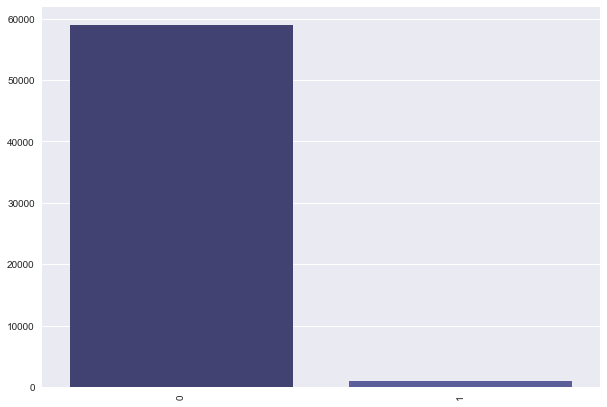

In [11]:
bar(train_labels.value_counts())
plt.show()

## Procesamiento y análisis

### Selección de variables mediante PCA

In [12]:
#Se realizará un PCA utilizando el 95 de la varianza
pca = PCA(0.95)
pca.fit(train_features)
train_features_pca = pca.transform(train_features) #Es un array
train_features_pca = pd.DataFrame(train_features_pca) #convertir a df 

In [13]:
print('Número de componentes principales',pca.n_components_)

Número de componentes principales 10


### Balanceo de datos

In [14]:
# Se selecciona una muestra class=0 con igual número de elementos de class =1
# Tomado de https://www.kaggle.com/romulomadu/minimizing-total-cost-result-9020-00
id_1 = train_labels[train_labels==1].index
id_0 = train_labels[train_labels==0].sample(n=1000, replace=False, random_state=0).index
id_balanced = np.concatenate((id_1,id_0)) #index de datos balanceados
#para pca
train_features_balanced_pca = train_features_pca.loc[id_balanced]

#labels a predecir
train_labels_balanced = train_labels.loc[id_balanced]


In [15]:
train_labels_balanced.value_counts()

1    1000
0    1000
Name: class, dtype: int64

### Random Forest
#### usando PCA

In [16]:
#Se definen los parámetros a probar
rfc_pca = RandomForestClassifier(n_estimators=20, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0, warm_start=False, class_weight=None)
rfc_pca.fit(train_features_balanced_pca, train_labels_balanced)
rfc_pca
    

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

## Predicción Random Forest

In [17]:
#Función que calcula el costo total de acuerdo al problema
def costo_total(cm):
    costo= 10*cm[0,1] + 500*cm[1,0]
    return costo

In [18]:
test_features_pca = pca.transform(test_features)
y_pred_rf_pca = rfc_pca.predict(test_features_pca)
cm_rf_pca =confusion_matrix(test_labels, y_pred_rf_pca)
print_binary_confusion_matrix (cm_rf_pca)

print('Costo total para Random forest y PCA es',costo_total(cm_rf_pca))

              +-----------------+
              |   Predicción    |
              +-----------------+
              |    +   |    -   |
+-------+-----+--------+--------+
| Valor |  +  |    364 |     11 |
| real  +-----+--------+--------+
|       |  -  |    993 |  14632 |
+-------+-----+--------+--------+
Costo total para Random forest y PCA es 15430


## Notas:

#### Hace falta utilizar otros métodos para reemplazar los datos faltantes (se sugiere utilizar MICE)
#### hace probar otros métodos de normalización
#### Hace falta utilizar otros métodos de reducción de dimensionalidad.
#### Hace falta utilizar Gridsearch para mejorar la búsqueda de hiperparámetros
